In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

In [2]:
raw_data=pd.read_csv('datasets/2010-05-09  to 2021-05-20.csv')

In [3]:
raw_data.head()

,Date,Traded Companies,Stock Symbol,No. Of Transaction,Max Price,Min Price,Closing Price,Traded Shares,Amount,Previous Closing,Difference Rs.,Sector
0,2010-05-09,Ace Development Bank Ltd.,NaN,1,210.0,210.0,210.0,110.0,23100.0,214.0,-4.0,NaN
1,2010-05-09,Api Finance Limited,NaN,8,240.0,224.0,225.0,230.0,53140.0,240.0,-15.0,NaN
2,2010-05-09,Arun Valley Hydropower Development Co. Ltd.,AHPC,1,421.0,421.0,421.0,40.0,16840.0,413.0,8.0,Hydro Power
3,2010-05-09,Axis Development Bank Limited,NaN,17,219.0,215.0,215.0,340.0,73820.0,215.0,0.0,NaN
4,2010-05-09,Bank of Kathmandu Ltd.,BOKL,17,679.0,652.0,665.0,1815.0,1196117.0,692.0,-27.0,Commercial Banks


## only taking necessary stock for prediction

In [4]:
data=raw_data[raw_data['Stock Symbol'].isin(['KBL','GBIME'])]

data.Date=pd.to_datetime(data.Date)

data=data.set_index(data.Date)

data=data.drop('Date',axis=1)

In [5]:
data=pd.pivot_table(data,index=data.index,columns='Stock Symbol',values='Closing Price')

In [6]:
data=data.replace(0,np.NaN)

## Filing missing values

In [7]:
data=data.fillna(method='ffill')
data.isna().any()

Stock Symbol
GBIME    False
KBL      False
dtype: bool

## setting the frequency

#### As of Nepal

In [8]:
data = data.asfreq('d')


##Monday=0, Sunday=6.
weekday=[]
for i in data.index:
    weekday.append(i.weekday())
data['weekday']=weekday
data=data[(data['weekday'] !=4) & (data['weekday'] !=5)]


data=data.fillna(method='ffill')

In [9]:
data.shape

(2880, 3)

#### As of Foreign(commenting it)

In [10]:
#data = data.asfreq('b')


#data=data.fillna(method='ffill')

In [11]:
#data.shape

## RETURNS

In [12]:
data['kbl_returns']=data.KBL.pct_change()*100

data['gbime_returns']=data.GBIME.pct_change()*100

data=data.dropna()

data.shape

(2879, 5)

## volatility

In [13]:
data['kbl_volatility']=data.kbl_returns.mul(data.kbl_returns)
data['gbime_volatility']=data.gbime_returns.mul(data.gbime_returns)

## PLOTTING 

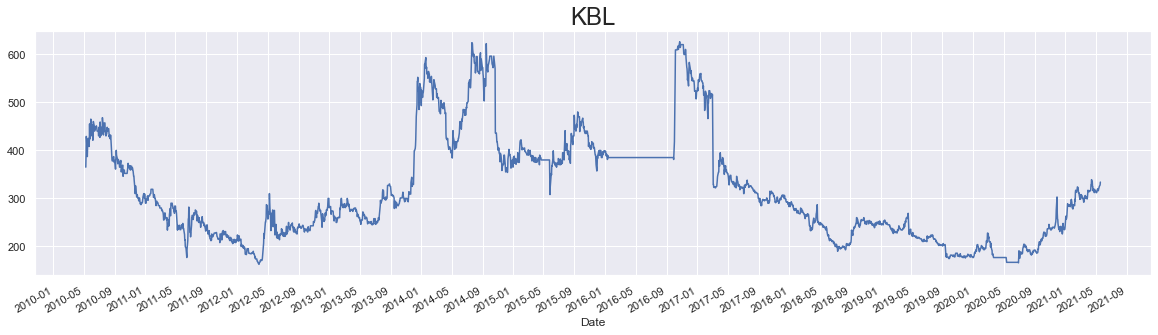

In [14]:
ax=data.KBL.plot(figsize=(20,5))

# Major ticks every 6 months.
fmt_half_year = mdates.MonthLocator(interval=4)
ax.xaxis.set_major_locator(fmt_half_year)

plt.title("KBL",size=24)

plt.show()

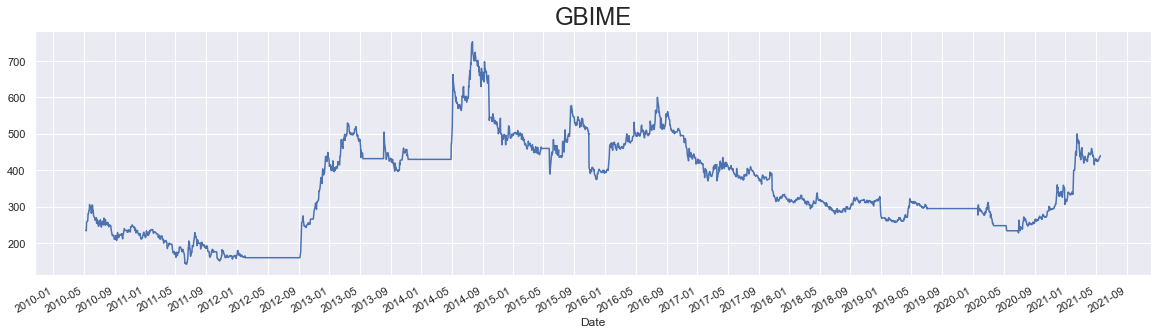

In [15]:
ax=data.GBIME.plot(figsize=(20,5))

# Major ticks every 6 months.
fmt_half_year = mdates.MonthLocator(interval=4)
ax.xaxis.set_major_locator(fmt_half_year)

plt.title("GBIME",size=24)
plt.show()

## Dickey-Fuller Test

In [16]:
#importing required module
import statsmodels.tsa.stattools as sts

In [17]:
sts.adfuller(data.KBL)

(-2.3887175579599953,
 0.14494614844904868,
 1,
 2877,
 {'1%': -3.43262498927583,
  '5%': -2.8625451360824843,
  '10%': -2.5673050630393703},
 20502.02150904765)

In [18]:
sts.adfuller(data.kbl_returns)

(-39.019299088916476,
 0.0,
 1,
 2877,
 {'1%': -3.43262498927583,
  '5%': -2.8625451360824843,
  '10%': -2.5673050630393703},
 13176.213464894561)

In [19]:
sts.adfuller(data.GBIME)

(-1.8286001626286548,
 0.3663577717897277,
 6,
 2872,
 {'1%': -3.4326289534601844,
  '5%': -2.862546886869174,
  '10%': -2.5673059951476556},
 19876.851796103725)

In [20]:
sts.adfuller(data.gbime_returns)

(-28.150095762520937,
 0.0,
 2,
 2876,
 {'1%': -3.4326257810090195,
  '5%': -2.862545485752566,
  '10%': -2.567305249201584},
 12080.808674474967)

## Autocorrelation

In [21]:
#importing the required package
import statsmodels.graphics.tsaplots as sgt

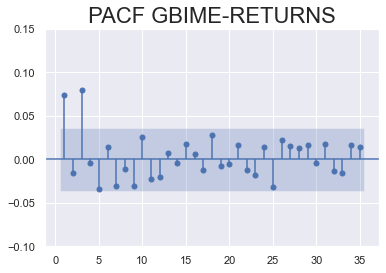

In [22]:
sgt.plot_pacf(data.gbime_returns,zero=False)
plt.title(" PACF GBIME-RETURNS ",size=22)
plt.ylim(-0.1,0.15)
plt.show()

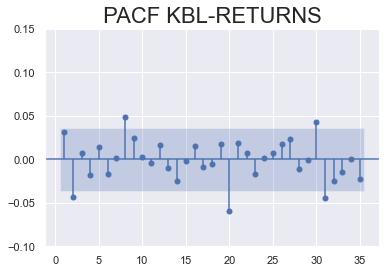

In [23]:
sgt.plot_pacf(data.kbl_returns,zero=False)
plt.title(" PACF KBL-RETURNS ",size=22)
plt.ylim(-0.1,0.15)
plt.show()

## Testing and Prediction

In [24]:
testing=int(len(data.KBL)*0.9)

df,df_test=data.iloc[:testing],data.iloc[testing:]

start_date="2020-04-14"
end_date="2020-10-20"

## ARIMA MODEL

In [25]:
#importing necessary models
from statsmodels.tsa.arima_model import ARIMA

In [26]:
model_ar_1_i_0_ma_0=ARIMA(df.gbime_returns,order=(1,0,0))
result_ar_1_i_0_ma_0=model_ar_1_i_0_ma_0.fit()
result_ar_1_i_0_ma_0.summary()

C:\Users\lfc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:          gbime_returns   No. Observations:                 2591
Model:                     ARMA(1, 0)   Log Likelihood               -5499.831
Method:                       css-mle   S.D. of innovations              2.021
Date:                Thu, 27 May 2021   AIC                          11005.662
Time:                        12:10:58   BIC                          11023.241
Sample:                             0   HQIC                         11012.032
                                                                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0228      0.042      0.537      0.591      -0.060       0.106
ar.L1.gbime_returns     0.0640      0.020      3.266      0.001       0.026       0.102
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           15.6184           +0.0000j           15.6184            0.0000
-----------------------------------------------------------------------------
"""

In [27]:
result_arima={}
for i in range(0,8):
    for j in range(0,8):
        key="result_ar_"+str(i)+"_i_0_ma_"+str(j)
        z=ARIMA(df.gbime_returns,order=(i,0,j))
        try:
            value=z.fit()
            result_arima[key]={value.llf,value.aic}
        except:
            for k in range(1,15):
                try:
                    value=z.fit(start_ar_lags=int(k))
                    result_arima[key]={value.llf,value.aic}
                    break
                except:
                    pass
                

C:\Users\lfc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\lfc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\lfc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\lfc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated 

C:\Users\lfc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\lfc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\lfc\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\lfc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecast

C:\Users\lfc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\lfc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\lfc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\lfc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated 

In [28]:
result_arima

{'result_ar_0_i_0_ma_0': {-5505.154691600708, 11014.309383201416},
 'result_ar_0_i_0_ma_1': {-5499.883496113439, 11005.766992226878},
 'result_ar_0_i_0_ma_2': {-5499.877437977079, 11007.754875954159},
 'result_ar_0_i_0_ma_3': {-5492.496472640154, 10994.992945280308},
 'result_ar_0_i_0_ma_4': {-5492.116973893396, 10996.233947786792},
 'result_ar_0_i_0_ma_5': {-5489.408083857224, 10992.816167714447},
 'result_ar_0_i_0_ma_6': {-5488.761226924016, 10993.522453848032},
 'result_ar_0_i_0_ma_7': {-5487.799711142791, 10993.599422285582},
 'result_ar_1_i_0_ma_0': {-5499.830941423168, 11005.661882846336},
 'result_ar_1_i_0_ma_1': {-5498.356686780272, 11004.713373560544},
 'result_ar_1_i_0_ma_2': {-5498.340586524564, 11006.681173049128},
 'result_ar_1_i_0_ma_3': {-5492.328589384562, 10996.657178769125},
 'result_ar_1_i_0_ma_4': {-5488.617874813696, 10991.235749627393},
 'result_ar_1_i_0_ma_5': {-5487.778279570375, 10991.55655914075},
 'result_ar_1_i_0_ma_6': {-5487.735846887314, 10993.47169377462

In [29]:
model_ar_2_i_0_ma_7=ARIMA(df.gbime_returns,order=(2,0,7))
result_ar_2_i_0_ma_7=model_ar_2_i_0_ma_7.fit(start_ar_lags=9)
result_ar_2_i_0_ma_7.summary()

C:\Users\lfc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:          gbime_returns   No. Observations:                 2591
Model:                     ARMA(2, 7)   Log Likelihood               -5486.783
Method:                       css-mle   S.D. of innovations              2.011
Date:                Thu, 27 May 2021   AIC                          10995.565
Time:                        12:17:16   BIC                          11060.023
Sample:                             0   HQIC                         11018.924
                                                                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0222      0.041      0.539      0.590      -0.058       0.103
ar.L1.gbime_returns     0.1988      0.397      0.501      0.616      -0.578       0.976
ar.L2.gbime_returns     0.4557      0.355      1.285      0.199      -0.239       1.151
ma.L1.gbime_returns    -0.1348      0.397     -0.339      0.734      -0.914       0.644
ma.L2.gbime_returns    -0.4606      0.335     -1.374      0.169      -1.118       0.196
ma.L3.gbime_returns     0.0457      0.032      1.446      0.148      -0.016       0.108
ma.L4.gbime_returns    -0.0098      0.038     -0.260      0.795      -0.084       0.064
ma.L5.gbime_returns    -0.0828      0.032     -2.606      0.009      -0.145      -0.021
ma.L6.gbime_returns     0.0201      0.038      0.524      0.600      -0.055       0.095
ma.L7.gbime_returns    -0.0181      0.033     -0.553      0.580      -0.082       0.046
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2792           +0.0000j            1.2792            0.0000
AR.2           -1.7153           +0.0000j            1.7153            0.5000
MA.1            1.2109           -0.0000j            1.2109           -0.0000
MA.2           -1.3308           -0.5157j            1.4273           -0.4412
MA.3           -1.3308           +0.5157j            1.4273            0.4412
MA.4            1.2922           -1.5799j            2.0411           -0.1409
MA.5            1.2922           +1.5799j            2.0411            0.1409
MA.6           -0.0129           -2.3160j            2.3160           -0.2509
MA.7           -0.0129           +2.3160j            2.3160            0.2509
-----------------------------------------------------------------------------
"""

In [30]:
model_ar_0_i_0_ma_5=ARIMA(df.gbime_returns,order=(0,0,5))
result_ar_0_i_0_ma_5=model_ar_0_i_0_ma_5.fit(start_ar_lags=9)
result_ar_0_i_0_ma_5.summary()

C:\Users\lfc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:          gbime_returns   No. Observations:                 2591
Model:                     ARMA(0, 5)   Log Likelihood               -5489.408
Method:                       css-mle   S.D. of innovations              2.013
Date:                Thu, 27 May 2021   AIC                          10992.816
Time:                        12:17:17   BIC                          11033.835
Sample:                             0   HQIC                         11007.681
                                                                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0226      0.044      0.513      0.608      -0.064       0.109
ma.L1.gbime_returns     0.0650      0.020      3.305      0.001       0.026       0.103
ma.L2.gbime_returns     0.0077      0.020      0.390      0.697      -0.031       0.046
ma.L3.gbime_returns     0.0742      0.019      3.857      0.000       0.036       0.112
ma.L4.gbime_returns     0.0116      0.020      0.578      0.563      -0.028       0.051
ma.L5.gbime_returns    -0.0454      0.019     -2.331      0.020      -0.084      -0.007
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.5707           -0.9496j            1.8354           -0.4135
MA.2           -1.5707           +0.9496j            1.8354            0.4135
MA.3            0.6126           -1.6228j            1.7346           -0.1926
MA.4            0.6126           +1.6228j            1.7346            0.1926
MA.5            2.1725           -0.0000j            2.1725           -0.0000
-----------------------------------------------------------------------------
"""

In [31]:
resul_pred=result_ar_2_i_0_ma_7.predict(start=2303,end=2403)

In [32]:
df_result=pd.DataFrame(data=resul_pred.values,index=df_test.iloc[:101].index)

<AxesSubplot:xlabel='Date'>

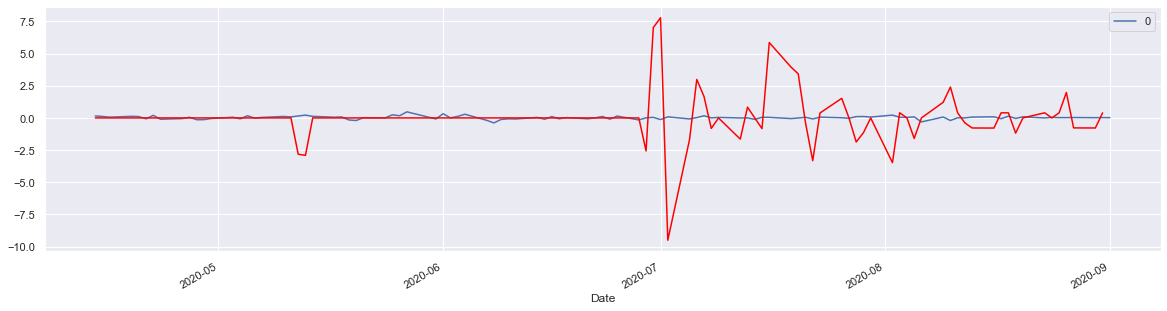

In [33]:
df_result.plot(figsize=(20,5))
df_test.gbime_returns.iloc[:100].plot(figsize=(20,5),color="red")

## AUTO ARIMA

In [34]:
#importing necessary models
from pmdarima.arima import auto_arima

In [35]:
model_autoarima=auto_arima(df.gbime_returns)

model_autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2591
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -5498.485
Date:                Thu, 27 May 2021   AIC                          11002.970
Time:                        12:17:26   BIC                          11020.550
Sample:                             0   HQIC                         11009.341
                               - 2591                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5586      0.131      4.275      0.000       0.302       0.815
ma.L1         -0.4983      0.138     -3.605      0.000      -0.769      -0.227
sigma2         4.0813      0.044     92.296      0.000       3.995       4.168
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             14615.17
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
model_autoarima_param=auto_arima(df[['kbl_returns']],exogenous=df[['gbime_returns']],m=5,max_order=None,max_p=7,max_q=7,max_d=2,max_P=4,max_Q=4,max_D=2,
                                maxiter=50,alpha=0.05,n_jobs=-1,trend='ct',information_criterion="aic")

model_autoarima_param.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2591
Model:                        SARIMAX   Log Likelihood               -5935.582
Date:                Thu, 27 May 2021   AIC                          11879.164
Time:                        12:17:35   BIC                          11902.603
Sample:                             0   HQIC                         11887.658
                               - 2591                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0246      0.085      0.288      0.773      -0.143       0.192
drift         -2.174e-05   7.11e-05     -0.306      0.760      -0.000       0.000
gbime_returns     0.3735      0.014     26.181      0.000       0.346       0.401
sigma2            5.7191      0.045    128.322      0.000       5.632       5.806
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):             92746.00
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                            -1.49
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## PREDICTION

In [37]:
df_auto_pred=pd.DataFrame(model_autoarima_param.predict(n_periods = len(df_test[start_date:end_date]),
                          exogenous=df_test[['gbime_returns']][start_date:end_date]),
                          index=df_test[start_date:end_date].index)

C:\Users\lfc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


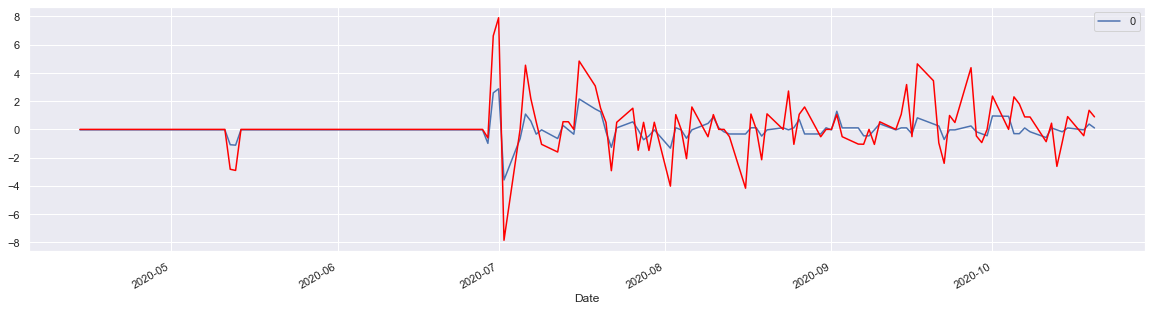

In [38]:
df_auto_pred.plot(figsize=(20,5))
df_test.kbl_returns[start_date:end_date].plot(color="red")
plt.show()

## Forecasting Volatility

In [39]:
#importing necessary module
from arch import arch_model

In [40]:
mod_garch=arch_model(data.gbime_volatility,vol="GARCH",p=1,q=1,mean="constant",dist="Normal")

##last_obs=start_date , will ensure we are only fitting the trainning datasets
# we set the update_freq to 10 to avoid unnecessary outputs in the screen
res_garch=mod_garch.fit(last_obs = start_date , update_freq=10)

Iteration:     10,   Func. Count:     58,   Neg. LLF: 10645.955614149952
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10644.240046533327
            Iterations: 19
            Function evaluations: 105
            Gradient evaluations: 19


In [41]:
pred_garch=res_garch.forecast(horizon=1,align='target')

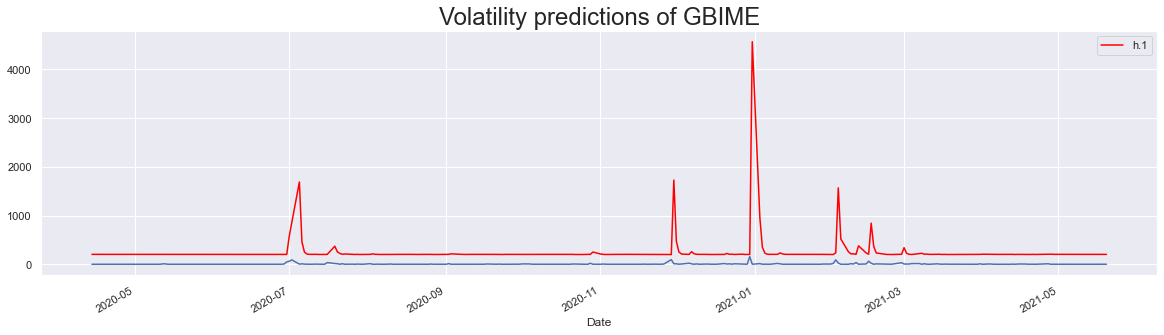

In [42]:
pred_garch.residual_variance[:].plot(figsize=(25,5),color='red',zorder=2)
df_test.gbime_volatility.abs().plot(figsize=(20,5),zorder=1)
plt.title("Volatility predictions of GBIME",size=24)
plt.show()

In [43]:
pred_garch=res_garch.forecast(horizon=100,align='target')
pred_garch.residual_variance[-1:]

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,
2021-05-20,202.842113,237.730316,250.056401,254.420591,256.104481,256.666971,256.86912,256.940512,256.966891,256.976038,...,256.981118,256.981118,256.981118,256.981118,256.981118,256.981118,256.981118,256.981118,256.981118,256.981118


## Multivariate Regression

In [44]:
from statsmodels.tsa.api import VAR

In [45]:
df_ret=df[['kbl_returns','gbime_returns']]

In [46]:
model_var_ret=VAR(df_ret)
model_var_ret.select_order(20)
results_var_ret=model_var_ret.fit()

C:\Users\lfc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [47]:
results_var_ret.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 27, May, 2021
Time:                     12:17:37
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    3.16899
Nobs:                     2590.00    HQIC:                   3.16034
Log likelihood:          -11430.4    FPE:                    23.4629
AIC:                      3.15542    Det(Omega_mle):         23.4086
--------------------------------------------------------------------
Results for equation kbl_returns
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.003207         0.049271            0.065           0.948
L1.kbl_returns           0.016591         0.020597            0.805           0.421
L1.gbime_returns         0.049137         

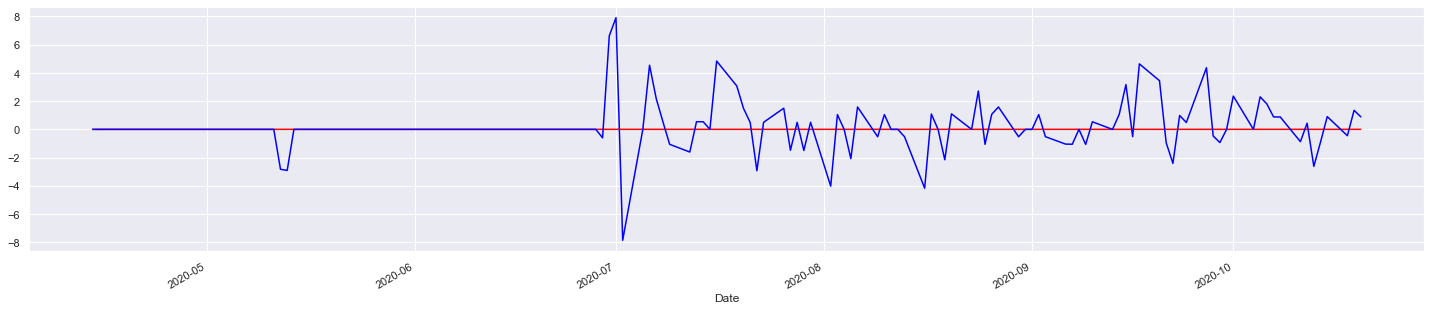

In [48]:
lag_order_ret=results_var_ret.k_ar
var_pred_ret=results_var_ret.forecast(df_ret.values[-lag_order_ret:],len(df_test[start_date:end_date]))

df_ret_pred=pd.DataFrame(data=var_pred_ret , index=df_test[start_date:end_date].index,
                        columns=['kbl_returns','gbime_returns'])
df_ret_pred.kbl_returns.plot(figsize=(25,5),color="red")
df_test.kbl_returns[start_date:end_date].plot(color="blue")
plt.show()

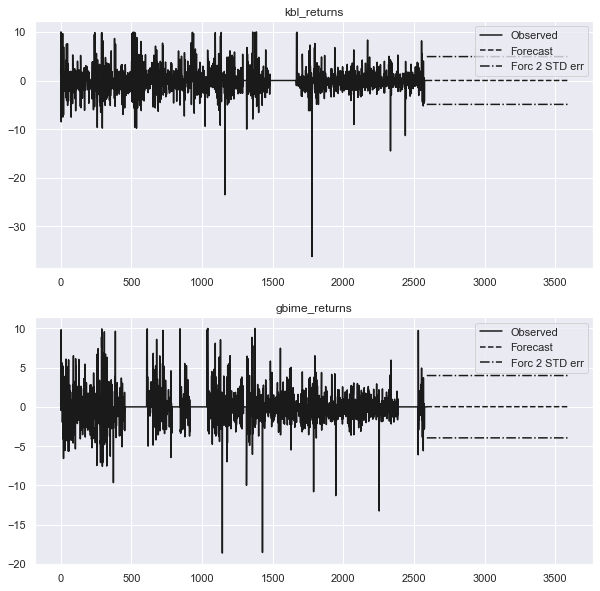

In [49]:
results_var_ret.plot_forecast(1000)
plt.show()